# Peptides and Proteins

Sequences of amino acids form peptides and proteins.

## Amino Acid Sequences

The
[AASequence](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.AASequence.html)
class handles amino acid sequences in OpenMS. A string of amino acid
residues can be turned into a instance of
[AASequence](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.AASequence.html)
to provide some commonly used operations like chemical formula, weight,
and isotope distribution calculations.

The example below shows how amino acid sequences can be created and how
basic mass calculations are conducted.

In [ ]:
import pyopenms as oms

seq = oms.AASequence.fromString(
    "DFPIANGER"
)  # create AASequence object from string representation
prefix = seq.getPrefix(4)  # extract prefix of length 4
suffix = seq.getSuffix(5)  # extract suffix of length 5
concat = seq + seq  # concatenate two sequences

# print string representation of sequences
print("Sequence:", seq)
print("Prefix:", prefix)
print("Suffix:", suffix)
print("Concatenated:", concat)

# some mass calculations
mfull = seq.getMonoWeight()  # weight of M
mprecursor = seq.getMonoWeight(oms.Residue.ResidueType.Full, 2)  # weight of M+2H

# we can calculate mass-over-charge manually
mz = seq.getMonoWeight(oms.Residue.ResidueType.Full, 2) / 2.0  # m/z of [M+2H]2+
# or simply by:
mz = seq.getMZ(2)  # same as above

print()
print("Monoisotopic mass of peptide [M] is", mfull)
print("Monoisotopic mass of peptide precursor [M+2H]2+ is", mprecursor)
print("Monoisotopic m/z of [M+2H]2+ is", mz)

Which prints the amino acid sequence as well as the result of
concatenating two sequences or taking the suffix of a sequence. We then
compute the mass of the full peptide (`[M]`), the mass of the peptide
precursor (`[M+2H]2+`) and m/z value of the peptide precursor
(`[M+2H]2+`). Note that, the mass of the peptide precursor is shifted by
two protons that are now attached to the molecules as charge carriers.
(Detail: the proton mass of $1.007276\ u$ is slightly different from the
mass of an uncharged hydrogen atom at $1.007825\ u$). We can easily
calculate the charged weight of a `(M+2H)2+` ion and compute m/z simply
dividing by the charge.

``` output
Sequence: DFPIANGER
Prefix: DFPI
Suffix: ANGER
Concatenated: DFPIANGERDFPIANGER

Monoisotopic mass of peptide [M] is 1017.4879641373001
Monoisotopic mass of peptide precursor [M+2H]2+ is 1019.5025170708421
Monoisotopic m/z of [M+2H]2+ is 509.7512585354211
```

The
[AASequence](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.AASequence.html)
object also allows iterations directly in Python:

In [ ]:
seq = oms.AASequence.fromString("DFPIANGER")

print("The peptide", str(seq), "consists of the following amino acids:")
for aa in seq:
    print(aa.getName(), ":", aa.getMonoWeight())

Which will print

``` output
The peptide DFPIANGER consists of the following amino acids:
Aspartate : 133.0375092233
Phenylalanine : 165.0789793509
Proline : 115.0633292871
Isoleucine : 131.0946294147
Alanine : 89.04767922330001
Asparagine : 132.0534932552
Glycine : 75.0320291595
Glutamate : 147.05315928710002
Arginine : 174.1116764466
```

The N- and C-Terminus as well as the residues themself can be modified.
The example below shows how to check for such modifications.

In [ ]:
seq = oms.AASequence.fromString("C[143]PKCK(Label:13C(6)15N(2))CR")

# check if AASequence has a N- or C-terminal modification
if seq.hasNTerminalModification():
    print("N-Term Modification: ", seq.getNTerminalModification().getFullId())
if seq.hasCTerminalModification():
    print("C-Term Modification: ", seq.getCTerminalModification().getFullId())
# iterate over all residues and look for modifications
for aa in seq:
    if aa.isModified():
        print(
            aa.getName(), ":", aa.getMonoWeight(), ":", aa.getModificationName()
        )
    else:
        print(aa.getName(), ":", aa.getMonoWeight())

Which will print:

``` output
N-Term Modification:  Pyro-carbamidomethyl (N-term C)
Cysteine : 121.01974995329999
Proline : 115.06332928709999
Lysine : 146.1055284466
Cysteine : 121.01974995329999
Lysine : 154.11972844660002 : Label:13C(6)15N(2)
Cysteine : 121.01974995329999
Arginine : 174.1116764466
```

### Molecular Formula

We can now combine our knowledge of
[AASequence](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.AASequence.html)
with what we learned in about
[EmpiricalFormula](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.EmpiricalFormula.html)
to get accurate mass and isotope distributions from the amino acid
sequence. But first, let's get the formula of peptide:

In [ ]:
seq = oms.AASequence.fromString("DFPIANGER")
seq_formula = seq.getFormula()
print("Peptide", seq, "has molecular formula", seq_formula)

### Isotope Patterns

We now want to print the coarse (e.g., peaks only at nominal masses)
distribution.

In [ ]:
# print coarse isotope distribution
coarse_isotopes = seq_formula.getIsotopeDistribution(
    oms.CoarseIsotopePatternGenerator(6)
)
for iso in coarse_isotopes.getContainer():
    print(
        "Isotope", iso.getMZ(), "has abundance", iso.getIntensity() * 100, "%"
    )

For most applications in computational proteomics, the coarse isotope
distribution is sufficient. But if we deal with very high resolution
instruments, we still might want to calculate the isotopic fine
structure. We use the
[FineIsotopePatternGenerator](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.FineIsotopePatternGenerator.html)
in OpenMS to reveal these additional peaks:

In [ ]:
# print fine structure of isotope distribution
fine_isotopes = seq_formula.getIsotopeDistribution(
    oms.FineIsotopePatternGenerator(0.01)
)  # max 0.01 unexplained probability
for iso in fine_isotopes.getContainer():
    print(
        "Isotope", iso.getMZ(), "has abundance", iso.getIntensity() * 100, "%"
    )

And plot the very similar looking distributions using standard
`matplotlib` functionality:

In [ ]:
import math
from matplotlib import pyplot as plt


def plotIsotopeDistribution(isotope_distribution, title="Isotope distribution"):
    plt.title(title)
    distribution = {"mass": [], "abundance": []}
    for iso in isotope_distribution.getContainer():
        distribution["mass"].append(iso.getMZ())
        distribution["abundance"].append(iso.getIntensity() * 100)

    bars = plt.bar(
        distribution["mass"], distribution["abundance"], width=0.01, snap=False
    )  # snap ensures that all bars are rendered

    plt.ylim([0, 110])
    plt.xticks(
        range(
            math.ceil(distribution["mass"][0]) - 2,
            math.ceil(distribution["mass"][-1]) + 2,
        )
    )
    plt.xlabel("Atomic mass (u)")
    plt.ylabel("Relative abundance (%)")


plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plotIsotopeDistribution(coarse_isotopes, "Isotope distribution - coarse")
plt.subplot(1, 2, 2)
plotIsotopeDistribution(fine_isotopes, "Isotope distribution - fine structure")
plt.show()

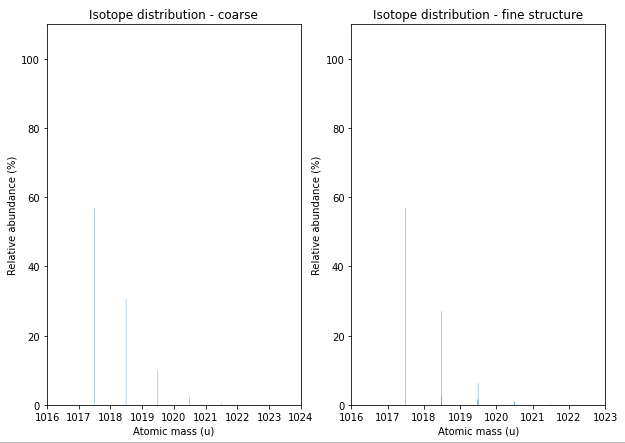

### Fragment Ions

We can easily calculate different ion types for amino acid sequences:

In [ ]:
suffix = seq.getSuffix(3)  # y3 ion "GER"
print("=" * 35)
print("y3 ion sequence:", suffix)
y3_formula = suffix.getFormula(oms.Residue.ResidueType.YIon, 2)  # y3++ ion
suffix.getMonoWeight(oms.Residue.ResidueType.YIon, 2) / 2.0  # CORRECT
suffix.getMonoWeight(oms.Residue.ResidueType.XIon, 2) / 2.0  # CORRECT
suffix.getMonoWeight(oms.Residue.ResidueType.BIon, 2) / 2.0  # INCORRECT

print("y3 mz:", suffix.getMonoWeight(oms.Residue.ResidueType.YIon, 2) / 2.0)
print("y3 molecular formula:", y3_formula)

Which will produce

``` output
===================================
y3 ion sequence: GER
y3 mz: 181.09514385
y3 molecular formula: C13H24N6O6
```

Easy, isn't it? To generate full theoretical spectra watch out for the
more specialized (and faster)
[TheoreticalSpectrumGenerator](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.TheoreticalSpectrumGenerator.html)
which we will take a look at later.

## Modified Sequences

The
[AASequence](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.AASequence.html)
class can also handle modifications, modifications are specified using a
unique string identifier present in the
[ModificationsDB](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.ModificationsDB.html)
in round brackets after the modified amino acid or by providing the mass
of the residue in square brackets. For example
`AASequence.fromString(".DFPIAM(Oxidation)GER.")` creates an instance of
the peptide "DFPIAMGER" with an oxidized methionine. There are multiple
ways to specify modifications, and
`AASequence.fromString("DFPIAM(UniMod:35)GER")`,
`AASequence.fromString("DFPIAM[+16]GER")` and
`AASequence.fromString("DFPIAM[147]GER")` are all equivalent).

In [ ]:
seq = oms.AASequence.fromString("PEPTIDESEKUEM(Oxidation)CER")
print(seq.toUnmodifiedString())
print(seq.toString())
print(seq.toUniModString())
print(seq.toBracketString())
print(seq.toBracketString(False))

print(oms.AASequence.fromString("DFPIAM(UniMod:35)GER"))
print(oms.AASequence.fromString("DFPIAM[+16]GER"))
print(oms.AASequence.fromString("DFPIAM[+15.99]GER"))
print(oms.AASequence.fromString("DFPIAM[147]GER"))
print(oms.AASequence.fromString("DFPIAM[147.035405]GER"))

The above code outputs:

``` output
PEPTIDESEKUEMCER
PEPTIDESEKUEM(Oxidation)CER
PEPTIDESEKUEM(UniMod:35)CER
PEPTIDESEKUEM[147]CER
PEPTIDESEKUEM[147.0354000171]CER

DFPIAM(Oxidation)GER
DFPIAM(Oxidation)GER
DFPIAM(Oxidation)GER
DFPIAM(Oxidation)GER
DFPIAM(Oxidation)GER
```

Note there is a subtle difference between
`AASequence.fromString(".DFPIAM[+16]GER.")` and
`AASequence.fromString(".DFPIAM[+15.9949]GER.")` - while the former will
try to find the first modification matching to a mass difference of
$16 \pm 0.5$, the latter will try to find the closest matching
modification to the exact mass. The exact mass approach usually gives
the intended results while the first approach may or may not. In all
instances, it is better to use an exact description of the desired
modification, such as UniMod, instead of mass differences.

N- and C-terminal modifications are represented by brackets to the right
of the dots terminating the sequence. For example,
`".(Dimethyl)DFPIAMGER."` and `".DFPIAMGER.(Label:18O(2))"` represent
the labelling of the N- and C-terminus respectively, but
`".DFPIAMGER(Phospho)."` will be interpreted as a phosphorylation of the
last arginine at its side chain:

In [ ]:
s = oms.AASequence.fromString(".(Dimethyl)DFPIAMGER.")
print(s, s.hasNTerminalModification())
s = oms.AASequence.fromString(".DFPIAMGER.(Label:18O(2))")
print(s, s.hasCTerminalModification())
s = oms.AASequence.fromString(".DFPIAMGER(Phospho).")
print(s, s.hasCTerminalModification())

Arbitrary / unknown amino acids (usually due to an unknown modification)
can be specified using tags preceded by `X`: `X[weight]`. This indicates
a new amino acid ("`X`") with the specified weight, e.g. `RX[148.5]T`.
Note that this tag does not alter the amino acids to the left (`R`) or
right (`T`). Rather, `X` represents an amino acid on its own. Be careful
when converting such
[AASequence](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.AASequence.html)
objects to an EmpiricalFormula using
[AASequence.getFormula](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.AASequence.getFormula.html),
as tags will not be considered in this case (there exists no formula for
them). However, they have an influence on
[AASequence.getMonoWeight](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.AASequence.getMonoWeight.html)
and
[AASequence.getAverageWeight](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.AASequence.getAverageWeight.html)!

## Applying Fixed or Variable Modifications to Sequences

In this tutorial, we will cover a step-by-step guide on how to use the
pyopenms library to generate modified peptides from a given amino acid
sequence.

> import pyopenms as poms

\# Create an amino acid sequence using the fromString() method of the
AASequence class. \# In this example, we will use the amino acid
sequence "TESTMTECSTMTESTR" sequence =
poms.AASequence.fromString("TESTMTECSTMTESTR")

\# We use the names "Oxidation (M)" and "Carbamidomethyl (C)" for the
variable and fixed modifications, respectively. variable_mod_names =
\[b"Oxidation (M)"\] fixed_mod_names = \[b"Carbamidomethyl (C)"\]

\# We then use the getModifications() method of the
ModifiedPeptideGenerator class to get the modifications for these names.
variable_modifications =
poms.ModifiedPeptideGenerator.getModifications(variable_mod_names)
fixed_modifications =
poms.ModifiedPeptideGenerator.getModifications(fixed_mod_names)

\# Apply the fixed modifications to the amino acid sequence
poms.ModifiedPeptideGenerator.applyFixedModifications(fixed_modifications,
sequence)

\# Define the maximum number of variable modifications allowed
max_variable_mods = 1

\# Generate the modified peptides peptides_with_variable_modifications =
\[\] keep_unmodified_in_result = False
poms.ModifiedPeptideGenerator.applyVariableModifications(variable_modifications,
sequence, max_variable_mods, peptides_with_variable_modifications,
keep_unmodified_in_result)

\# Print the modified peptides generated using Fixed modifications and
their mono-isotopic mass. print("Fixed:", sequence.toString())
print("Mono-isotopic mass:", sequence.getMonoWeight())

\# Print the modified peptides generated using variable modifications
and their mono-isotopic mass. for peptide in
peptides_with_variable_modifications: print("Variable:",
peptide.toString()) print("Mono-isotopic mass:",
peptide.getMonoWeight())

The above code outputs:

``` output
Fixed: TESTMTEC(Carbamidomethyl)STMTESTR
Mono-isotopic mass: 1850.7332409542007
Variable: TESTMTEC(Carbamidomethyl)STM(Oxidation)TESTR
Mono-isotopic mass: 1866.7281559542005
Variable: TESTM(Oxidation)TEC(Carbamidomethyl)STMTESTR
Mono-isotopic mass: 1866.7281559542005
```

## Proteins and [FASTA](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-FASTA) Files

Protein sequences, can be loaded from and stored in
[FASTA](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-FASTA)
protein databases using
[FASTAFile](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.FASTAFile.html).
The example below shows how protein sequences can be stored in
[FASTA](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-FASTA)
files and loaded back in pyOpenMS:

In [ ]:
bsa = oms.FASTAEntry()  # one entry in a FASTA file
bsa.sequence = "MKWVTFISLLLLFSSAYSRGVFRRDTHKSEIAHRFKDLGE"
bsa.description = "BSA Bovine Albumin (partial sequence)"
bsa.identifier = "BSA"
alb = oms.FASTAEntry()
alb.sequence = "MKWVTFISLLFLFSSAYSRGVFRRDAHKSEVAHRFKDLGE"
alb.description = "ALB Human Albumin (partial sequence)"
alb.identifier = "ALB"

entries = [bsa, alb]

f = oms.FASTAFile()
f.store("example.fasta", entries)

Afterwards, the `example.fasta` file can be read again from the disk:

In [ ]:
entries = []
f = oms.FASTAFile()
f.load("example.fasta", entries)
print(len(entries))
for e in entries:
    print(e.identifier, e.sequence)